<a href="https://colab.research.google.com/github/kassemm/assignment1/blob/master/Lab2MoustafaKassem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**params[0]** => crosstrack_error  **params[1]** => diff_crosstrack_error  **params[2]**  =>int_crosstrack_error

In [87]:
# --------------
# User Instructions
# 
# Finish the PID in the run function 
#
#
# --------------


 
from math import *
import random
import matplotlib.pyplot as plt

# ------------------------------------------------
# 
# this is the robot class
#

class robot:

    # --------
    # init: 
    #    creates robot and initializes location/orientation to 0, 0, 0
    #

    def __init__(self, length = 20.0):
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    # --------
    # set: 
    #	sets a robot coordinate
    #

    def set(self, new_x, new_y, new_orientation):

        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation) % (2.0 * pi)


    # --------
    # set_noise: 
    #	sets the noise parameters
    #

    def set_noise(self, new_s_noise, new_d_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = float(new_s_noise)
        self.distance_noise = float(new_d_noise)

    # --------
    # set_steering_drift: 
    #	sets the systematical steering drift parameter
    #

    def set_steering_drift(self, drift):
        self.steering_drift = drift
        
    # --------
    # move: 
    #    steering = front wheel steering angle, limited by max_steering_angle
    #    distance = total distance driven, most be non-negative

    def move(self, steering, distance, 
             tolerance = 0.001, max_steering_angle = pi / 4.0):

        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0


        # make a new copy
        res = robot()
        res.length         = self.length
        res.steering_noise = self.steering_noise
        res.distance_noise = self.distance_noise
        res.steering_drift = self.steering_drift

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = tan(steering2) * distance2 / res.length

        if abs(turn) < tolerance:

            # approximate by straight line motion

            res.x = self.x + (distance2 * cos(self.orientation))
            res.y = self.y + (distance2 * sin(self.orientation))
            res.orientation = (self.orientation + turn) % (2.0 * pi)

        else:

            # approximate bicycle model for motion

            radius = distance2 / turn
            cx = self.x - (sin(self.orientation) * radius)
            cy = self.y + (cos(self.orientation) * radius)
            res.orientation = (self.orientation + turn) % (2.0 * pi)
            res.x = cx + (sin(res.orientation) * radius)
            res.y = cy - (cos(res.orientation) * radius)

        return res

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]'  % (self.x, self.y, self.orientation)
   
    def cte(self, radius):#Refer to L6 Control, p 28. 
        center1 = [radius, radius] 
        center2 = [radius, 3*radius]
        if self.x > radius and self.x < 3*radius: #If x lies in the center straight line segment
            if self.y > radius: #If y is above the center line, then compute vertical distance from (x,y) to the top edge of the track
                cte = self.y - (2*radius)
            else: #If y is below the center line, then compute vertical distance from the bottom edge of the track to (x,y)
                cte = -1.0 * self.y
        else:
            if self.x < 2*radius: #If x lies in the left semi-circle segment (self.x <= radius), then compute Euclidian distance from (x,y) to the perimeter of the left semi-circle 
                cte = ((self.x - center1[1])**2 + (self.y - center1[0])**2)**0.5 - radius
            else: #If x lies in the right semi-circle part (self.x >= 3*radius), then compute Euclidian distance from (x,y) to the perimeter of the right semi-circle
                cte = ((self.x - center2[1])**2 + (self.y - center2[0])**2)**0.5 - radius                
        
       
        return cte
# ------------------------------------------------------------------------
#
# run - does a single control run.


def run(params, radius, printflag = False):
    myrobot = robot()
    myrobot.set(0.0, radius, pi / 2.0)
    speed = 1.0 # motion distance is equal to speed (we assume time = 1) 
    err = 0.0
    int_crosstrack_error = 0.0
    N =1000
    crosstrack_error = myrobot.cte(radius)
    x_trajectory = []
    y_trajectory = []
    for i in range(N*2):
        diff_crosstrack_error = - crosstrack_error
        crosstrack_error = myrobot.cte(radius)
        diff_crosstrack_error += crosstrack_error
        int_crosstrack_error += crosstrack_error
        steer = -params[0] * crosstrack_error - params[1] * diff_crosstrack_error - params[2] * int_crosstrack_error
        myrobot = myrobot.move(steer, speed)

        if i >= N:
            err += crosstrack_error ** 2
            x_trajectory.append(myrobot.x)
            y_trajectory.append(myrobot.y)
        #if printflag:
        #    print (myrobot)
    if printflag:
      plt.plot(x_trajectory,y_trajectory, color="r", linestyle="--", marker="*", linewidth=1.0)
      plt.show()
    if printflag:
      print('**********************************************************************************')
      print('\nFinal parameters: ', params)
      print('\nError: ', err)
    return err / float(N)  

def twiddle(pd_in,radius,tol=0.2):  
    p = [0.9, 0.0, 0.0]
    dp=dp_in;
    #dp = [1.0, 1.0, 1.0]
    best_err = run(p, radius)
    it = 0
    while sum(dp) > tol:
        # print("Iteration {}, best error = {}".format(it, best_err))
        for i in range(len(p)):
            p[i] += dp[i]
            err = run(p, radius)
            if err < best_err:
                best_err = err
                dp[i] *= 1.1
            else:
                p[i] -= 2 * dp[i]
                err = run(p, radius)
                if err < best_err:
                    best_err = err
                    dp[i] *= 1.1
                else:
                    p[i] += dp[i]
                    dp[i] *= 0.9
        it += 1
    return p, best_err




Below is PIDControl RaceTrack Twiddle.py 
Radius=50
**Controller**= PID  => pd_in=[1.0, 1.0, 1.0] 

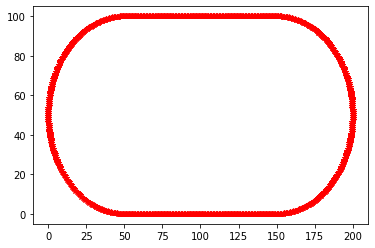

**********************************************************************************

Final parameters:  [4.552740717693687, 22.449962603710926, 4.232642289128589]

Error:  0.03652316110206372


In [88]:
radius = 50.0  #change Radius to 50.0 
dp_in=[1.0, 1.0, 1.0]

params,err = twiddle(dp,radius)
err = run(params, radius,True)

Below is PIDControl RaceTrack Twiddle.py 
Radius=50
**Controller**= PI  => pd_in=[1.0, 0.0, 1.0] 

---



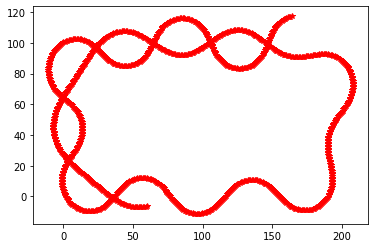

**********************************************************************************

Final parameters:  [0.08999999999999989, 0.0, 0.0]

Error:  94515.7345252424


In [89]:
radius = 50.0  #change Radius to 50.0 
dp_in=[1.0, 0.0, 1.0]

params,err = twiddle(dp,radius)
err = run(params, radius,True)

Below is PIDControl RaceTrack Twiddle.py 
Radius=50
**Controller**= P  => pd_in=[1.0, 0.0, 0.0] 

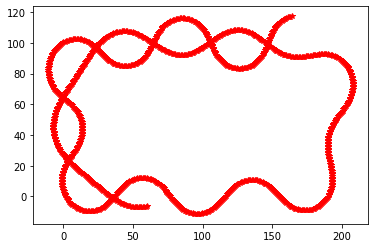

**********************************************************************************

Final parameters:  [0.08999999999999989, 0.0, 0.0]

Error:  94515.7345252424


In [90]:
radius = 50.0  #change Radius to 50.0 
dp_in=[1.0, 0.0, 0.0]

params,err = twiddle(dp,radius)
err = run(params, radius,True)

Below is PIDControl RaceTrack Twiddle.py 
Radius=50
**Controller**= PD  => pd_in=[1.0, 1.0, 0.0] 

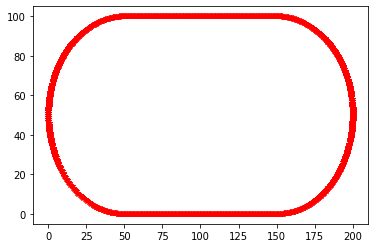

**********************************************************************************

Final parameters:  [11.939722492486624, 16.149222419737008, 0.0]

Error:  0.6344948052570877


In [91]:
radius = 50.0  #change Radius to 50.0 
dp_in=[1.0, 1.0, 0.0]

params,err = twiddle(dp,radius)
err = run(params, radius,True)


In [92]:
##Task two speed =10  

With speed =10 => (speed =10.0 dt=1)

In [93]:
# --------------
# User Instructions
# 
# Finish the PID in the run function 
#
#
# --------------


 
from math import *
import random
import matplotlib.pyplot as plt

# ------------------------------------------------
# 
# this is the robot class
#

class robot:

    # --------
    # init: 
    #    creates robot and initializes location/orientation to 0, 0, 0
    #

    def __init__(self, length = 20.0):
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    # --------
    # set: 
    #	sets a robot coordinate
    #

    def set(self, new_x, new_y, new_orientation):

        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation) % (2.0 * pi)


    # --------
    # set_noise: 
    #	sets the noise parameters
    #

    def set_noise(self, new_s_noise, new_d_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = float(new_s_noise)
        self.distance_noise = float(new_d_noise)

    # --------
    # set_steering_drift: 
    #	sets the systematical steering drift parameter
    #

    def set_steering_drift(self, drift):
        self.steering_drift = drift
        
    # --------
    # move: 
    #    steering = front wheel steering angle, limited by max_steering_angle
    #    distance = total distance driven, most be non-negative

    def move(self, steering, distance, 
             tolerance = 0.001, max_steering_angle = pi / 4.0):

        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0


        # make a new copy
        res = robot()
        res.length         = self.length
        res.steering_noise = self.steering_noise
        res.distance_noise = self.distance_noise
        res.steering_drift = self.steering_drift

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = tan(steering2) * distance2 / res.length

        if abs(turn) < tolerance:

            # approximate by straight line motion

            res.x = self.x + (distance2 * cos(self.orientation))
            res.y = self.y + (distance2 * sin(self.orientation))
            res.orientation = (self.orientation + turn) % (2.0 * pi)

        else:

            # approximate bicycle model for motion

            radius = distance2 / turn
            cx = self.x - (sin(self.orientation) * radius)
            cy = self.y + (cos(self.orientation) * radius)
            res.orientation = (self.orientation + turn) % (2.0 * pi)
            res.x = cx + (sin(res.orientation) * radius)
            res.y = cy - (cos(res.orientation) * radius)

        return res

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]'  % (self.x, self.y, self.orientation)
   
    def cte(self, radius):#Refer to L6 Control, p 28. 
        center1 = [radius, radius] 
        center2 = [radius, 3*radius]
        if self.x > radius and self.x < 3*radius: #If x lies in the center straight line segment
            if self.y > radius: #If y is above the center line, then compute vertical distance from (x,y) to the top edge of the track
                cte = self.y - (2*radius)
            else: #If y is below the center line, then compute vertical distance from the bottom edge of the track to (x,y)
                cte = -1.0 * self.y
        else:
            if self.x < 2*radius: #If x lies in the left semi-circle segment (self.x <= radius), then compute Euclidian distance from (x,y) to the perimeter of the left semi-circle 
                cte = ((self.x - center1[1])**2 + (self.y - center1[0])**2)**0.5 - radius
            else: #If x lies in the right semi-circle part (self.x >= 3*radius), then compute Euclidian distance from (x,y) to the perimeter of the right semi-circle
                cte = ((self.x - center2[1])**2 + (self.y - center2[0])**2)**0.5 - radius                
        
       
        return cte
# ------------------------------------------------------------------------
#
# run - does a single control run.


def run(params, radius, printflag = False,dt=1 ):
    myrobot = robot()
    myrobot.set(0.0, radius, pi / 2.0)
    speed =  10.0  
    err = 0.0
    int_crosstrack_error = 0.0
    N =1000
    crosstrack_error = myrobot.cte(radius)
    x_trajectory = []
    y_trajectory = []
    for i in range(N*2):
        diff_crosstrack_error = - crosstrack_error
        crosstrack_error = myrobot.cte(radius)
        diff_crosstrack_error += crosstrack_error  #
        #diff_crosstrack_error = (diff_crosstrack_error + crosstrack_error)/dt # cte -prev(olddiff_crosstrack_error)  #mkas
        int_crosstrack_error += crosstrack_error
        #int_crosstrack_error = (int_crosstrack_error+ crosstrack_error)/dt   #mkas
        steer = -params[0] * crosstrack_error - params[1] * diff_crosstrack_error - params[2] * int_crosstrack_error
        myrobot = myrobot.move(steer, speed)

        if i >= N:
            err += crosstrack_error ** 2
            x_trajectory.append(myrobot.x)
            y_trajectory.append(myrobot.y)
        #if printflag:
        #    print (myrobot)
    if printflag:
      plt.plot(x_trajectory,y_trajectory, color="r", linestyle="--", marker="*", linewidth=1.0)
      plt.show()
    if printflag:
      print('**********************************************************************************')
      print('\nFinal parameters: ', params)
      print('\nError: ', err)
    return err / float(N)  

def twiddle(pd_in,radius,tol=0.2):  
    p = [0.9, 0.0, 0.0]
    dp=dp_in;
    #dp = [1.0, 1.0, 1.0]
    best_err = run(p, radius)
    it = 0
    while sum(dp) > tol:
        # print("Iteration {}, best error = {}".format(it, best_err))
        for i in range(len(p)):
            p[i] += dp[i]
            err = run(p, radius)
            if err < best_err:
                best_err = err
                dp[i] *= 1.1
            else:
                p[i] -= 2 * dp[i]
                err = run(p, radius)
                if err < best_err:
                    best_err = err
                    dp[i] *= 1.1
                else:
                    p[i] += dp[i]
                    dp[i] *= 0.9
        it += 1
    return p, best_err




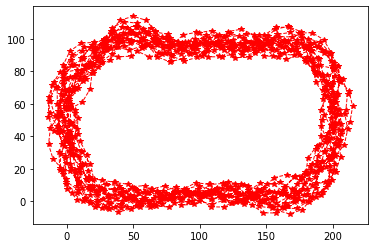

**********************************************************************************

Final parameters:  [0.7376030844089747, 1.2657765699559422, 0.04239115827521625]

Error:  36257.4479438168


In [94]:
radius = 50.0  #change Radius to 50.0 
dp_in=[1.0, 1.0, 1.0]
params,err = twiddle(dp,radius)
err = run(params, radius,True,dt=1.0)

With speed =10 => (speed =1.0 dt=0.1)  **Better** error

In [95]:
# --------------
# User Instructions
# 
# Finish the PID in the run function 
#
#
# --------------


 
from math import *
import random
import matplotlib.pyplot as plt

# ------------------------------------------------
# 
# this is the robot class
#

class robot:

    # --------
    # init: 
    #    creates robot and initializes location/orientation to 0, 0, 0
    #

    def __init__(self, length = 20.0):
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    # --------
    # set: 
    #	sets a robot coordinate
    #

    def set(self, new_x, new_y, new_orientation):

        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation) % (2.0 * pi)


    # --------
    # set_noise: 
    #	sets the noise parameters
    #

    def set_noise(self, new_s_noise, new_d_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = float(new_s_noise)
        self.distance_noise = float(new_d_noise)

    # --------
    # set_steering_drift: 
    #	sets the systematical steering drift parameter
    #

    def set_steering_drift(self, drift):
        self.steering_drift = drift
        
    # --------
    # move: 
    #    steering = front wheel steering angle, limited by max_steering_angle
    #    distance = total distance driven, most be non-negative

    def move(self, steering, distance, 
             tolerance = 0.001, max_steering_angle = pi / 4.0):

        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0


        # make a new copy
        res = robot()
        res.length         = self.length
        res.steering_noise = self.steering_noise
        res.distance_noise = self.distance_noise
        res.steering_drift = self.steering_drift

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = tan(steering2) * distance2 / res.length

        if abs(turn) < tolerance:

            # approximate by straight line motion

            res.x = self.x + (distance2 * cos(self.orientation))
            res.y = self.y + (distance2 * sin(self.orientation))
            res.orientation = (self.orientation + turn) % (2.0 * pi)

        else:

            # approximate bicycle model for motion

            radius = distance2 / turn
            cx = self.x - (sin(self.orientation) * radius)
            cy = self.y + (cos(self.orientation) * radius)
            res.orientation = (self.orientation + turn) % (2.0 * pi)
            res.x = cx + (sin(res.orientation) * radius)
            res.y = cy - (cos(res.orientation) * radius)

        return res

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]'  % (self.x, self.y, self.orientation)
   
    def cte(self, radius):#Refer to L6 Control, p 28. 
        center1 = [radius, radius] 
        center2 = [radius, 3*radius]
        if self.x > radius and self.x < 3*radius: #If x lies in the center straight line segment
            if self.y > radius: #If y is above the center line, then compute vertical distance from (x,y) to the top edge of the track
                cte = self.y - (2*radius)
            else: #If y is below the center line, then compute vertical distance from the bottom edge of the track to (x,y)
                cte = -1.0 * self.y
        else:
            if self.x < 2*radius: #If x lies in the left semi-circle segment (self.x <= radius), then compute Euclidian distance from (x,y) to the perimeter of the left semi-circle 
                cte = ((self.x - center1[1])**2 + (self.y - center1[0])**2)**0.5 - radius
            else: #If x lies in the right semi-circle part (self.x >= 3*radius), then compute Euclidian distance from (x,y) to the perimeter of the right semi-circle
                cte = ((self.x - center2[1])**2 + (self.y - center2[0])**2)**0.5 - radius                
        
       
        return cte
# ------------------------------------------------------------------------
#
# run - does a single control run.


def run(params, radius, printflag = False,dt=1 ):
    myrobot = robot()
    myrobot.set(0.0, radius, pi / 2.0)
    speed =  1.0  
    err = 0.0
    int_crosstrack_error = 0.0
    N =1000
    crosstrack_error = myrobot.cte(radius)
    x_trajectory = []
    y_trajectory = []
    for i in range(N*2):
        diff_crosstrack_error = - crosstrack_error
        crosstrack_error = myrobot.cte(radius)
        diff_crosstrack_error += crosstrack_error  #
        #diff_crosstrack_error = (diff_crosstrack_error + crosstrack_error)/dt # cte -prev(olddiff_crosstrack_error)  #mkas
        int_crosstrack_error += crosstrack_error
        #int_crosstrack_error = (int_crosstrack_error+ crosstrack_error)/dt   #mkas
        steer = -params[0] * crosstrack_error - params[1] * diff_crosstrack_error - params[2] * int_crosstrack_error
        myrobot = myrobot.move(steer, speed)

        if i >= N:
            err += crosstrack_error ** 2
            x_trajectory.append(myrobot.x)
            y_trajectory.append(myrobot.y)
        #if printflag:
        #    print (myrobot)
    if printflag:
      plt.plot(x_trajectory,y_trajectory, color="r", linestyle="--", marker="*", linewidth=1.0)
      plt.show()
    if printflag:
      print('**********************************************************************************')
      print('\nFinal parameters: ', params)
      print('\nError: ', err)
    return err / float(N)  

def twiddle(pd_in,radius,tol=0.2):  
    p = [0.9, 0.0, 0.0]
    dp=dp_in;
    #dp = [1.0, 1.0, 1.0]
    best_err = run(p, radius)
    it = 0
    while sum(dp) > tol:
        # print("Iteration {}, best error = {}".format(it, best_err))
        for i in range(len(p)):
            p[i] += dp[i]
            err = run(p, radius)
            if err < best_err:
                best_err = err
                dp[i] *= 1.1
            else:
                p[i] -= 2 * dp[i]
                err = run(p, radius)
                if err < best_err:
                    best_err = err
                    dp[i] *= 1.1
                else:
                    p[i] += dp[i]
                    dp[i] *= 0.9
        it += 1
    return p, best_err




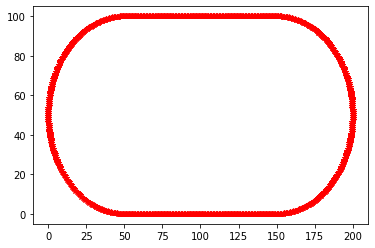

**********************************************************************************

Final parameters:  [4.552740717693687, 22.449962603710926, 4.232642289128589]

Error:  0.03652316110206372


In [96]:
radius = 50.0  #change Radius to 50.0 
dp_in=[1.0, 1.0, 1.0]
params,err = twiddle(dp,radius)
err = run(params, radius,True,dt=0.1)